In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.16.1


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (540, 540)

In [3]:
Training_Dir = '/kaggle/input/dermata2/train'
Validation_Dir = '/kaggle/input/fixdataset/valid'
Testing_Dir = '/kaggle/input/fixdataset/test'

In [4]:
# Fungsi untuk memuat dataset dari direktori dengan file _classes.csv untuk multilabel

def load_multilabel_dataset(data_dir, image_size, batch_size):
    # Path ke file CSV
    classes_path = os.path.join(data_dir, '_classes.csv')

    # Baca file CSV
    df = pd.read_csv(classes_path)
    df['filename'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))  # Sesuaikan path file gambar

    # Mengambil paths dan labels dalam bentuk multilabel
    image_paths = df['filename'].values
    labels = df.iloc[:, 1:].values  # Mengambil kolom kelas saja (dari kolom kedua hingga akhir)

    # Membuat tf.data.Dataset dari paths dan labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Memproses gambar dan label
    dataset = dataset.map(lambda x, y: process_image(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch dan prefetch untuk performa
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Fungsi untuk memproses setiap path gambar dan label
def process_image(file_path, label, image_size):
    # Load gambar
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    # image = image / 255.0  # Normalisasi ke [0, 1]
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image, label

In [5]:
# def load_multilabel_dataset(data_dir, image_size, batch_size):
#     # Path ke file CSV yang berisi nama file gambar
#     classes_path = os.path.join(data_dir, '_classes.csv')
#     df = pd.read_csv(classes_path)
    
#     # Menambahkan path lengkap untuk gambar
#     df['filename'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))
    
#     # Menghapus baris yang tidak memiliki file yang ada
#     df = df[df['filename'].apply(os.path.exists)]
    
#     # Mengecualikan file CSV atau file non-gambar lainnya jika diperlukan
#     df = df[df['filename'].apply(lambda x: x.endswith(('.jpg', '.jpeg', '.png', '.bmp')))]
    
#     # Mendapatkan path gambar dan label
#     image_paths = df['filename'].values
#     labels = df.iloc[:, 1:].values  # Asumsi label mulai dari kolom kedua
    
#     # Membuat dataset
#     dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
#     dataset = dataset.map(lambda x, y: process_image(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

#     return dataset
    
# def process_image(file_path, label, image_size):
#     # Muat file dengan error handling
#     def decode_image(image, file_path):
#         # Tentukan format file berdasarkan string
#         file_ext = tf.strings.split(file_path, '.')[-1]
#         file_ext = tf.strings.lower(file_ext)
        
#         # Decode berdasarkan format
#         if tf.equal(file_ext, 'jpg') or tf.equal(file_ext, 'jpeg'):
#             image = tf.image.decode_jpeg(image, channels=3)
#         elif tf.equal(file_ext, 'png'):
#             image = tf.image.decode_png(image, channels=3)
#         else:
#             # Jika format tidak didukung, raise error
#             raise ValueError(f"Format tidak didukung: {file_path}")
#         return image

#     try:
#         # Membaca file gambar
#         image = tf.io.read_file(file_path)
#         image = decode_image(image, file_path)
        
#         # Resize dan preprocess
#         image = tf.image.resize(image, image_size)
#         image = tf.keras.applications.inception_v3.preprocess_input(image)
#         return image, label

#     except (tf.errors.InvalidArgumentError, ValueError):
#         # Tangani file yang rusak atau format tidak didukung
#         print(f"File rusak atau format tidak didukung: {file_path}")
#         return tf.zeros(image_size + (3,)), label  # Gambar dummy kosong

In [6]:
train_dataset = load_multilabel_dataset(Training_Dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_dataset = load_multilabel_dataset(Validation_Dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_dataset = load_multilabel_dataset(Testing_Dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 540, 540, 3)
Label batch shape: (32, 10)


In [7]:
# Fungsi untuk menghitung jumlah gambar untuk masing-masing label
def count_labels(data_dir):
    # Path ke file CSV
    classes_path = os.path.join(data_dir, '_classes.csv')

    # Baca file CSV
    df = pd.read_csv(classes_path)

    # Menghitung jumlah gambar untuk masing-masing label
    label_counts = df.iloc[:, 1:].sum(axis=0)  # Mengambil kolom kelas dan menjumlahkan

    return label_counts


In [8]:
# Menghitung dan menampilkan jumlah gambar untuk masing-masing label
train_label_counts = count_labels(Training_Dir)

print("Jumlah gambar untuk masing-masing label di training set:")
print(train_label_counts)

Jumlah gambar untuk masing-masing label di training set:
Acne            2105
Blackheads        72
Dark Spots       190
Dry Skin         326
Eye bags         156
Normal Skin      178
Oily Skin        179
Pores            197
Skin Redness     182
Wrinkles         297
dtype: int64


In [9]:
pre_trained_model = tf.keras.applications.InceptionV3(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = pre_trained_model(image_batch)
print(feature_batch.shape)

(32, 15, 15, 2048)


In [11]:
pre_trained_model.trainable = False

In [12]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 540, 540,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 269, 269,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 269, 269,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 269, 269,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 267, 267,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 267, 267,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 267, 267,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 267, 267,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 267, 267,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 267, 267,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 133, 133,  │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 133, 133,  │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 133, 133,  │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 133, 133,  │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 131, 131,  │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 131, 131,  │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 131, 131,  │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [13]:
len(pre_trained_model.layers)

311

In [14]:
# for layer in pre_trained_model.layers[-30:]:
#     layer.trainable = True

In [15]:
# last_layer = pre_trained_model.get_layer('mixed8')
# print('last layer output shape: ', last_layer.output.shape)
# last_output = last_layer.output

In [16]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [18]:
inputs = pre_trained_model.input  # Input tensor
x = pre_trained_model(inputs, training=False)  # Explicitly pass `training=False`
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 540, 540, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 15, 15, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,437,034 (93.22 MB)

 Trainable params: 2,631,178 (10.04 MB)

 Non-trainable params: 21,805,856 (83.18 MB)

In [19]:
len(model.trainable_variables)

10

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        '''
        Halts the training when the loss falls below 0.4

        Args:
            epoch (integer) - index of epoch (required but unused in the function definition below)
            logs (dict) - metric results from the training epoch
        '''

        # Check the loss
        if logs['accuracy'] >= 0.90 and logs['val_accuracy'] >= 0.83:

            # Stop if threshold is met
            print("\nAccuracy 85% so stopping training!")
            self.model.stop_training = True

In [22]:
initial_epochs = 15

In [23]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = initial_epochs,
                    callbacks=[myCallback()],
                    verbose = 1
                   )

Epoch 1/15


I0000 00:00:1733475356.636983      89 service.cc:145] XLA service 0x7b5328004a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733475356.637039      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/111 ━━━━━━━━━━━━━━━━━━━━ 50:31 28s/step - accuracy: 0.0938 - loss: 2.9490

I0000 00:00:1733475376.528177      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 438ms/step - accuracy: 0.2676 - loss: 2.8275 - val_accuracy: 0.5645 - val_loss: 2.5064
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.4957 - loss: 2.5722 - val_accuracy: 0.6151 - val_loss: 2.3220
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.5563 - loss: 2.3756 - val_accuracy: 0.7368 - val_loss: 2.1289
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.6387 - loss: 2.1934 - val_accuracy: 0.7327 - val_loss: 1.9691
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.6857 - loss: 2.0199 - val_accuracy: 0.7709 - val_loss: 1.7780
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.7146 - loss: 1.8533 - val_accuracy: 0.7822 - val_loss: 1.6823
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.7352 - loss: 1.6949 - val_accuracy: 0.7812 - val_loss: 1.4936
Epoch 8/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.7766 - loss: 1.5480 - val

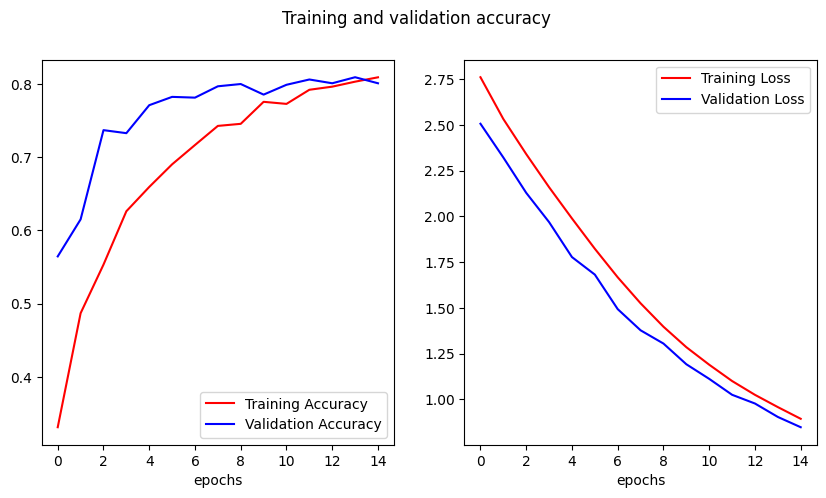

In [24]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [25]:
pre_trained_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained_model.layers))

Number of layers in the base model:  311


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 240

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 540, 540, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 15, 15, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,437,034 (93.22 MB)

 Trainable params: 14,631,306 (55.81 MB)

 Non-trainable params: 9,805,728 (37.41 MB)

In [30]:
len(model.trainable_variables)

50

In [32]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         verbose = 1
                        )

Epoch 15/30


I0000 00:00:1733475871.414840      86 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_27', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 4 by

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7582 - loss: 0.8819

I0000 00:00:1733475910.768759      86 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 4 by

111/111 ━━━━━━━━━━━━━━━━━━━━ 79s 472ms/step - accuracy: 0.7581 - loss: 0.8818 - val_accuracy: 0.8080 - val_loss: 0.8035
Epoch 16/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.8204 - loss: 0.8067 - val_accuracy: 0.8080 - val_loss: 0.7638
Epoch 17/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.8604 - loss: 0.7542 - val_accuracy: 0.8194 - val_loss: 0.7275
Epoch 18/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - accuracy: 0.8841 - loss: 0.7118 - val_accuracy: 0.8277 - val_loss: 0.6961
Epoch 19/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.8965 - loss: 0.6750 - val_accuracy: 0.8256 - val_loss: 0.6684
Epoch 20/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.9166 - loss: 0.6421 - val_accuracy: 0.8246 - val_loss: 0.6442
Epoch 21/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.9289 - loss: 0.6112 - val_accuracy: 0.8369 - val_loss: 0.6220
Epoch 22/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.9336 - loss: 0.584

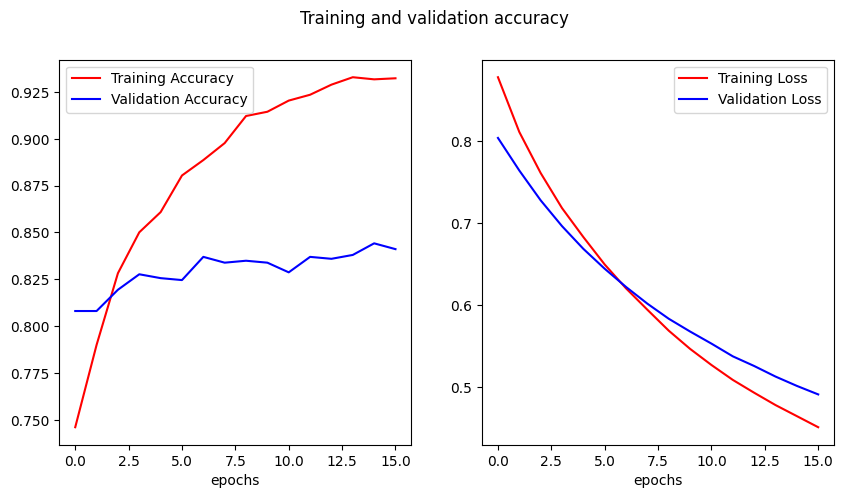

In [33]:
# Get training and validation accuracies
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step - accuracy: 0.8862 - loss: 0.4651
Test Loss: 0.4701775312423706, Test Accuracy: 0.8918918967247009


In [35]:
# Save the entire model
model.save('/kaggle/working/Dermata_inceptionV3_V3.h5')  # Add .keras extension to the filepath

In [43]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def load_and_process_image(img_path, target_size=(540, 540, 3)):
    img = image.load_img(img_path, target_size=target_size[:2])  # Sesuaikan ukuran tanpa channel
    img_array = image.img_to_array(img)  # Mengonversi gambar ke array
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    # img_array = img_array / 255.0 # Normalisasi
    return img_array

# Daftar label yang sesuai dengan output model
labels = [
    "Acne", "Blackheads", "Dark Spots", "Dry Skin",
    "Eye Bags", "Normal Skin", "Oily Skin", "Pores",
    "Redness", "Wrinkles"
]

# Path ke direktori gambar
test_dir = '/kaggle/input/fix-test-data/test dataset'
# test_dir = '/kaggle/input/skin-problem-multilabel-v1i-multiclass/test'

# Iterasi untuk setiap gambar dalam direktori
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    
    # Pastikan hanya memproses file gambar
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # Memuat dan memproses gambar
    img_array = load_and_process_image(img_path, target_size=(540, 540, 3))

    # Prediksi menggunakan model
    predictions = model.predict(img_array)

    # Menentukan label yang diprediksi berdasarkan ambang batas 0.3 untuk multilabel
    predicted_labels = (predictions >= 0.2).astype(int)

    # Menggabungkan label yang diprediksi dengan koma, serta persentase
    if any(predicted_labels[0]):
        result = []
        for i in range(len(labels)):
            if predicted_labels[0][i] == 1:
                result.append(f"{labels[i]} ({predictions[0][i] * 100:.2f}%)")
        print(f"Gambar: {filename}")
        print("    Diagnosis:", ", ".join(result))
    else:
        print(f"Gambar: {filename}")
        print("    Diagnosis: Tidak ada masalah kulit yang terdeteksi.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Gambar: darkspot2.jpg
    Diagnosis: Dark Spots (97.58%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Gambar: normal3.jpg
    Diagnosis: Dark Spots (63.75%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Gambar: dry3.jpg
    Diagnosis: Dry Skin (68.85%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Gambar: redness5.jpg
    Diagnosis: Acne (21.77%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Gambar: oily4.jpg
    Diagnosis: Dark Spots (23.29%), Oily Skin (86.52%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Gambar: wrinkle2.jpg
    Diagnosis: Wrinkles (99.62%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Gambar: oily2.jpg
    Diagnosis: Oily Skin (28.85%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Gambar: darkspot4.jpg
    Diagnosis: Acne (61.91%), Dark Spots (60.46%), Oily Skin (20.74%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Gambar: normal5.jpg
    Diagnosis: Acne (53.36%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Gambar: eyebag4.jpg
    Diagnosis: Dark Spots (51.93%), Wrinkles (44.35%)
1/1 ━━━━━━━━━━

In [44]:
model.save('/kaggle/working/Dermata_inceptionV3_V3.keras')

In [ ]:
# from tensorflow.keras.preprocessing import image



# # Fungsi untuk memuat dan memproses gambar

# def load_and_process_image(img_path, target_size=(224, 224)):

#     img = image.load_img(img_path, target_size=target_size)  # Memuat gambar dan mengubah ukurannya

#     img_array = image.img_to_array(img)  # Mengonversi gambar ke array

#     img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch (1, height, width, channels)

#     img_array = img_array / 255.0  # Normalisasi gambar (dari 0-255 ke 0-1)

#     return img_array



# # Daftar label yang sesuai dengan output model (sesuaikan dengan 10 kelas Anda)

# labels = [

#     "Acne", "Blackheads", "Dark Spots", "Dry Skin",

#     "Eye Bags", "Normal Skin", "Oily Skin", "Pores",

#     "Redness", "Wrinkles"

# ]



# # Memuat dan memproses gambar

# # img_path = '/kaggle/input/test-aja-bang-dermata1/dryskin3.jpeg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/dryskin2.jpeg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/test_oily.jpeg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/test_acne.jpeg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/WIN_20241113_01_53_43_Pro.jpg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/eye_bags.jpeg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/milia.jpeg'
# # img_path = '/kaggle/input/test-aja-bang-dermata1/WIN_20241113_12_05_56_Pro.jpg'


# img_array = load_and_process_image(img_path)



# # Prediksi menggunakan model

# predictions = model.predict(img_array)



# # Menentukan label yang diprediksi berdasarkan ambang batas 0.5 untuk multilabel
# predicted_labels = (predictions > 0.5).astype(int)



# # Menggabungkan label yang diprediksi dengan koma

# predicted_diagnosis = [labels[i] for i in range(len(labels)) if predicted_labels[0][i] == 1]



# # Menampilkan hasil dalam format yang diinginkan

# if predicted_diagnosis:

#     print("Anda didiagnosis:", ", ".join(predicted_diagnosis))

# else:

#     print("Tidak ada masalah kulit yang terdeteksi.")

In [ ]:
# import gc

# from tensorflow.keras import backend as K



# # Hapus model yang tidak terpakai

# del model  # Hapus objek model



# # Hapus objek lain yang sudah tidak terpakai, seperti history atau variabel training lainnya

# del history



# # Clear session untuk melepaskan memori

# K.clear_session()



# # Panggil garbage collector untuk membersihkan memori

# gc.collect()


In [ ]:
# # convert to tflite

# converter = tf.lite.TFLiteConverter.from_saved_model(DERMATA_MODEL)

# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model = converter.convert()